# Dataset Preview  & Processing

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [30]:
# Image directory paths
base_dir = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"

categories = ['lung_aca', 'lung_n', 'lung_scc']
img_size = 128  # Resize all images to 128x128

def load_images_from_folder(folder, label, show_progress=False):
    images = []
    labels = []
    file_list = os.listdir(folder)

    if show_progress:
        file_list = tqdm(file_list, desc=f"Loading {os.path.basename(folder)}")

    for filename in file_list:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label)
    return images, labels

In [31]:
from tqdm.notebook import tqdm  # instead of plain tqdm
import cv2

data = []
labels = []

# Use tqdm in the loops
for idx, category in enumerate(tqdm(categories, desc="Loading categories")):
    folder_path = os.path.join(base_dir, category)
    imgs, lbls = load_images_from_folder(folder_path, idx, show_progress=True)
    data.extend(imgs)
    labels.extend(lbls)


Loading categories:   0%|          | 0/3 [00:00<?, ?it/s]

Loading lung_aca:   0%|          | 0/5000 [00:00<?, ?it/s]

Loading lung_n:   0%|          | 0/5000 [00:00<?, ?it/s]

Loading lung_scc:   0%|          | 0/5000 [00:00<?, ?it/s]

# Labeling Data

In [32]:
data = np.array(data)  # Convert list to NumPy array
data = data / 255.0  # Normalize
labels = to_categorical(labels, num_classes=3)

# Train test Split

In [33]:
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# CNN Model

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = X_train.shape[1:]  # Shape of your images, e.g., (height, width, channels)
num_classes = y_train.shape[1]   # Number of categories, e.g., 3

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_layer = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', name='conv2d')(input_layer)
x = MaxPooling2D((2, 2), name='max_pooling2d')(x)
x = Conv2D(64, (3, 3), activation='relu', name='conv2d_1')(x)
x = MaxPooling2D((2, 2), name='max_pooling2d_1')(x)
x = Conv2D(128, (3, 3), activation='relu', name='conv2d_2')(x)
x = MaxPooling2D((2, 2), name='max_pooling2d_2')(x)
x = Flatten(name='flatten')(x)
x = Dense(128, activation='relu', name='dense')(x)
x = Dropout(0.5, name='dropout')(x)
output_layer = Dense(3, activation='softmax', name='dense_1')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val),
    shuffle=True
)

Epoch 1/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.7120 - loss: 0.5775 - val_accuracy: 0.8138 - val_loss: 0.4485
Epoch 2/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8772 - loss: 0.3163 - val_accuracy: 0.9062 - val_loss: 0.2362
Epoch 3/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9000 - loss: 0.2395 - val_accuracy: 0.9338 - val_loss: 0.1707
Epoch 4/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9216 - loss: 0.1911 - val_accuracy: 0.9267 - val_loss: 0.1814
Epoch 5/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9208 - loss: 0.1933 - val_accuracy: 0.9449 - val_loss: 0.1371
Epoch 6/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9330 - loss: 0.1618 - val_accuracy: 0.9462 - val_loss: 0.1343
Epoch 7/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9417 - loss: 0.1344 - val_accuracy: 0.9507 - val_loss: 0.1202
Epoch 8/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9619 - loss: 0.0975 - val_acc

# Evaluation

In [36]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)

print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

71/71 - 0s - 6ms/step - accuracy: 0.9684 - loss: 0.2324
329/329 - 2s - 7ms/step - accuracy: 0.9999 - loss: 4.8821e-04
Train Accuracy: 99.99%
Test Accuracy: 96.84%


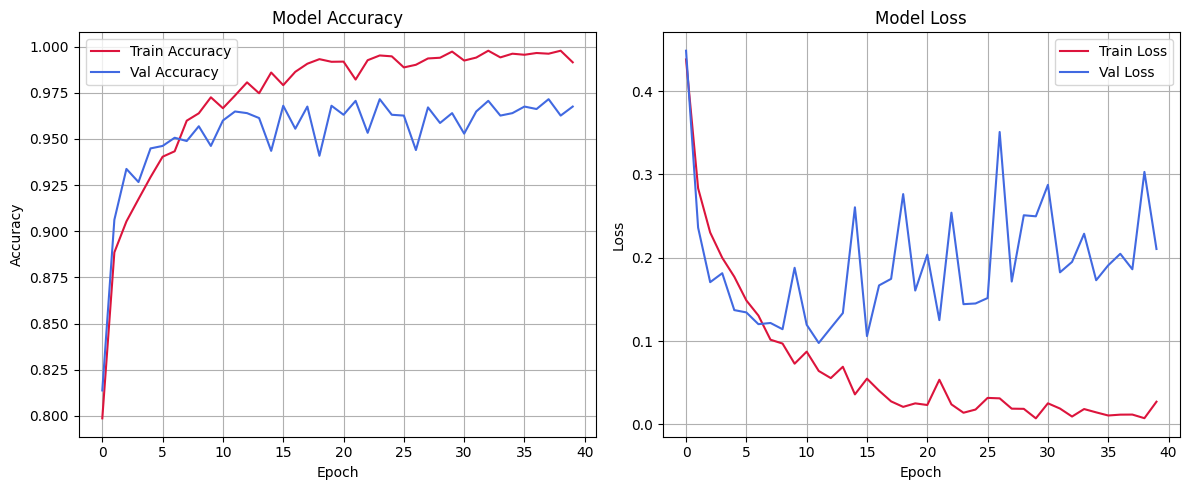

In [37]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='crimson')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='royalblue')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='crimson')
plt.plot(history.history['val_loss'], label='Val Loss', color='royalblue')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


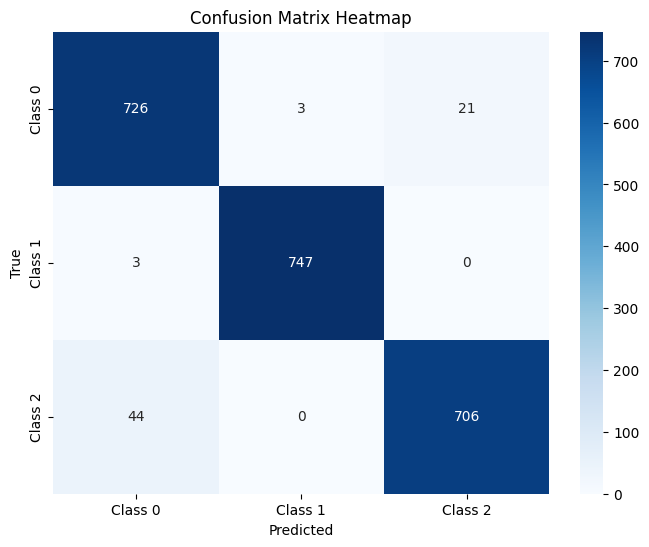

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Predict classes for test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Visualizing Classifications

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


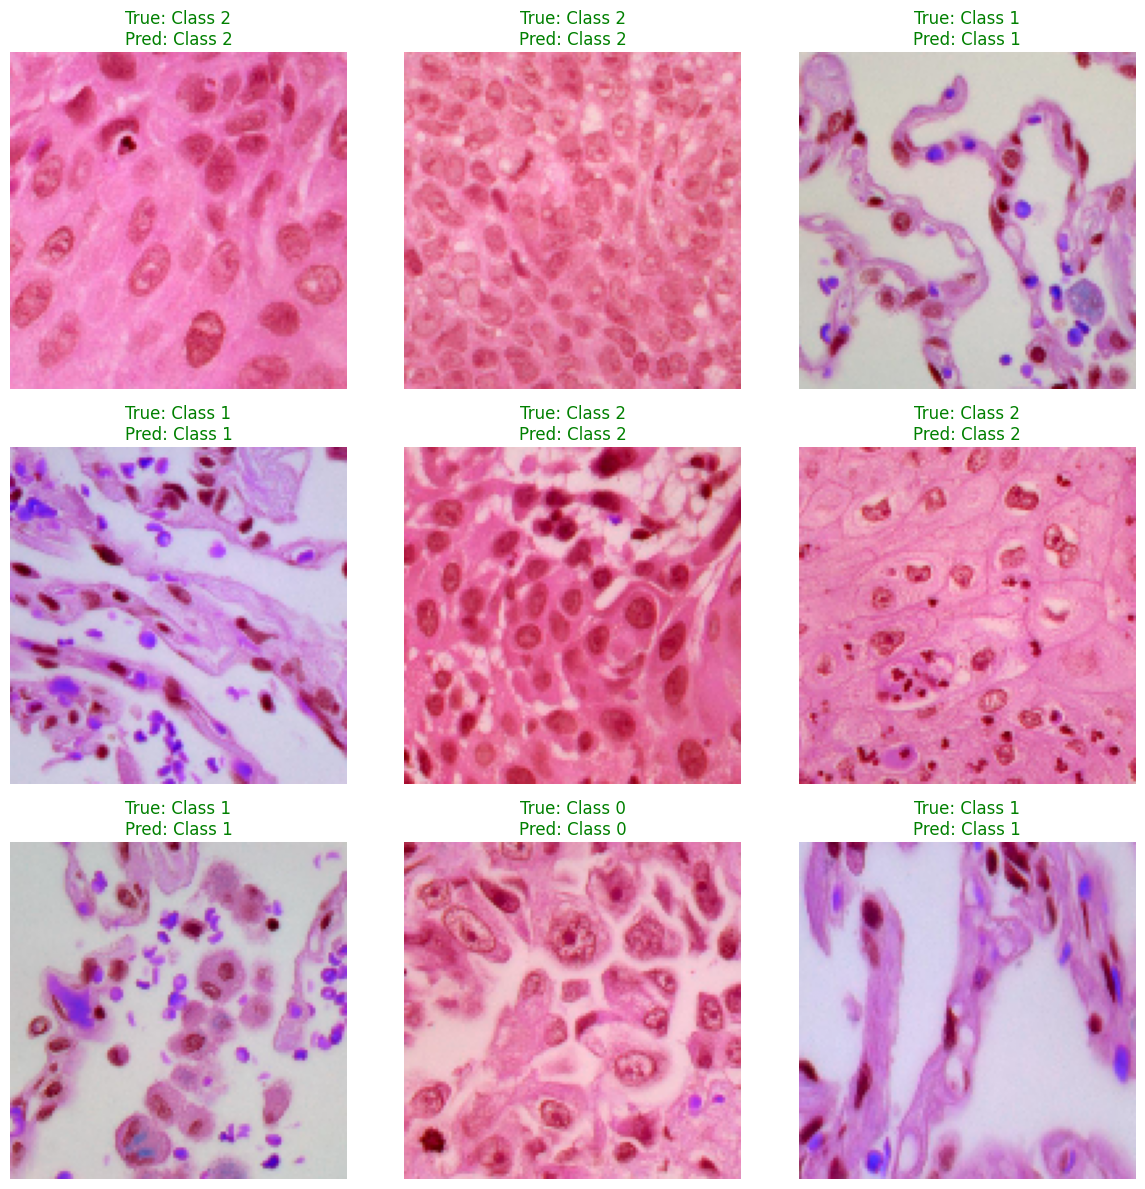

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Get predictions as class indices
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Define class names if you have them (replace with your classes)
class_names = ['Class 0', 'Class 1', 'Class 2']

# Plot some random images with their predicted and true labels
num_images = 9
plt.figure(figsize=(12, 12))

for i in range(num_images):
    idx = np.random.randint(0, len(X_test))
    img = X_test[idx]
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", color='green' if true_label == pred_label else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Visualizing Misclassifications

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


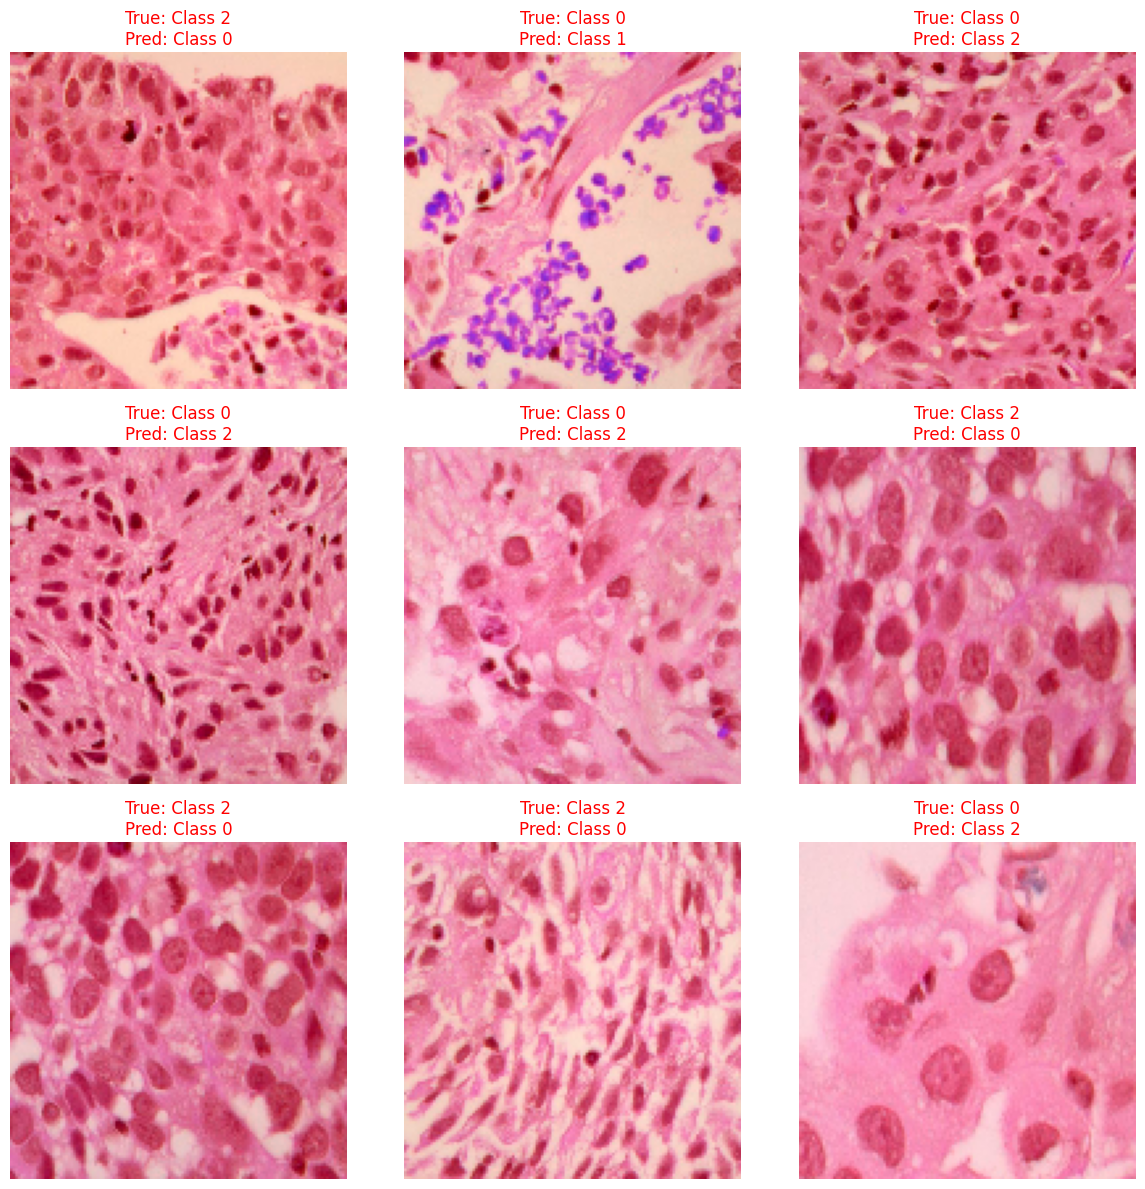

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Predict classes for test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Find indices where predictions are wrong
misclassified_indices = np.where(y_pred != y_true)[0]

# Number of misclassified images to show
num_to_show = 9
num_to_show = min(num_to_show, len(misclassified_indices))

plt.figure(figsize=(12, 12))

for i in range(num_to_show):
    idx = misclassified_indices[i]
    img = X_test[idx]
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Enhanced Interpretability through Grad-CAM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


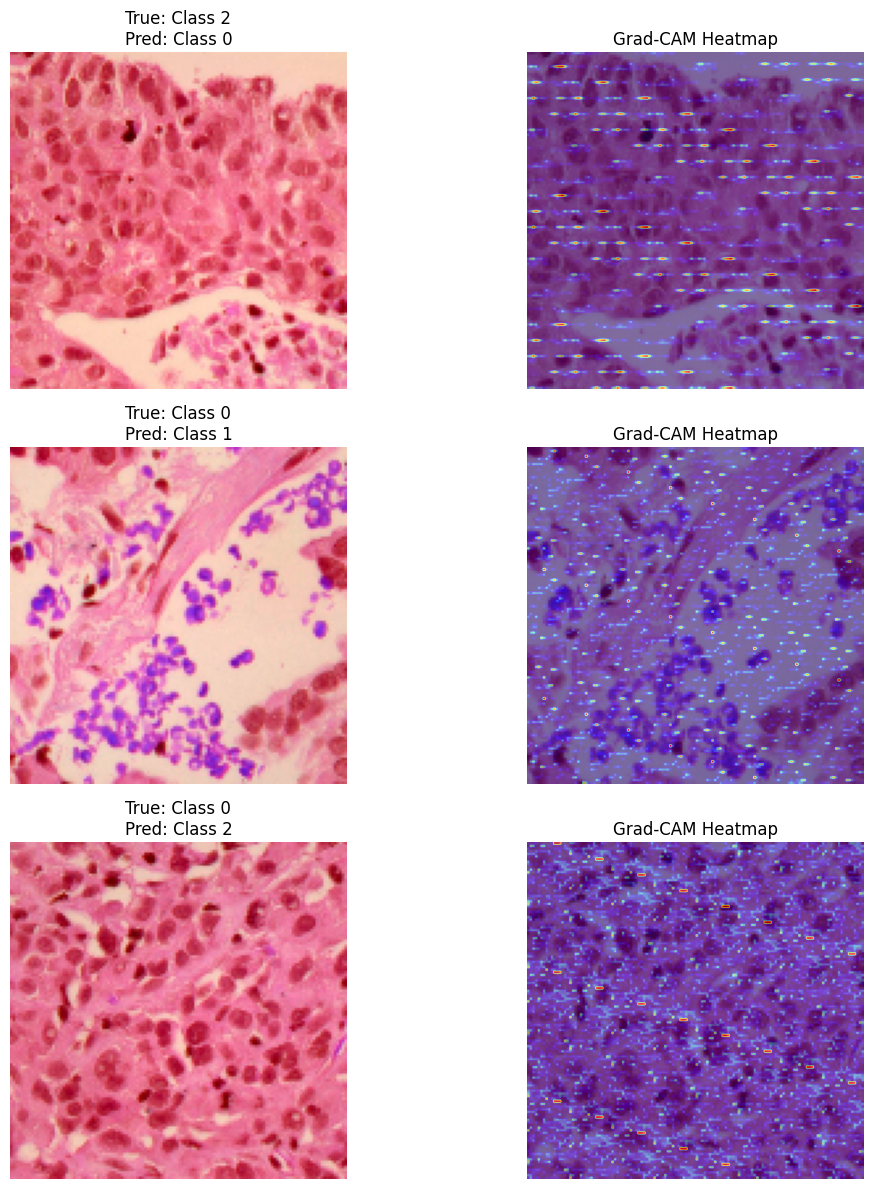

In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Run the model for dummy test
_ = model.predict(X_test[:1])

# Set the correct layer name
last_conv_layer_name = 'conv2d_2'  # change this based on your model summary

# Now run the Grad-CAM
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Name of the last conv layer (check your model summary for this)
last_conv_layer_name = 'conv2d_2'  # adjust if your layer has a different name

num_to_show = 3  # Show 3 misclassified images for clarity

plt.figure(figsize=(12, num_to_show * 4))

for i in range(num_to_show):
    idx = misclassified_indices[i]
    img = X_test[idx]
    img_array = np.expand_dims(img, axis=0)

    heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)
    
    # Rescale heatmap to image size
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.resize(heatmap, (img.shape[0], img.shape[1]))
    
    # Plot original image
    plt.subplot(num_to_show, 2, 2*i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
    plt.axis('off')
    
    # Plot heatmap overlay
    plt.subplot(num_to_show, 2, 2*i + 2)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Why It Was Misclassified:**
- True Class: 0 likely shows clear cellular structure but the model predicted Class 2, so it may have confused patterns that looked visually similar in cell density or color gradient.
- Look at the Grad-CAM heatmap – it’s too spread out. That means the model isn't focusing sharply on distinctive features. It might be attending to irrelevant textures or background noise, not the nuclei or cell boundaries.

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


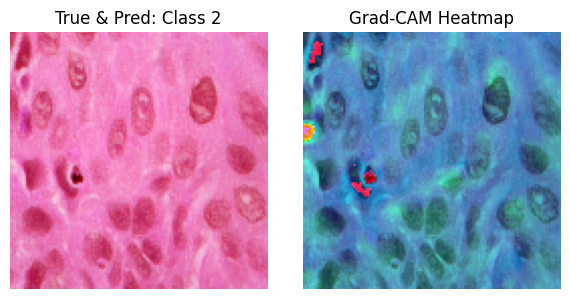

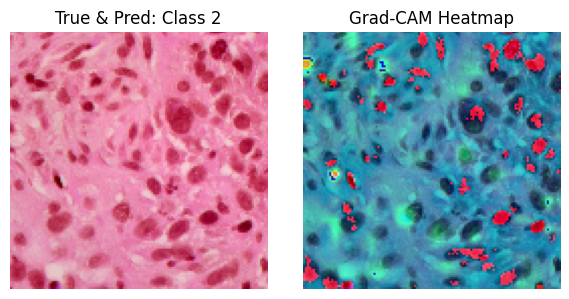

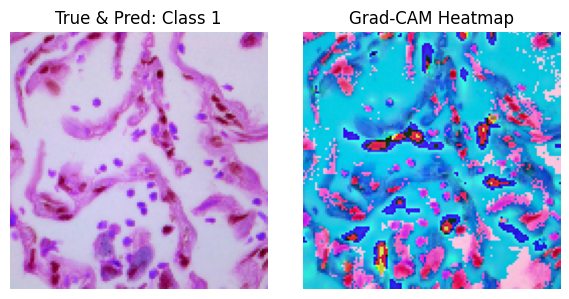

In [42]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2

# 🔍 Step 1: Get predictions
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 💖 Step 2: Find correct predictions
correct_indices = np.where(y_pred_classes == y_true_classes)[0]
sample_correct = random.sample(list(correct_indices), 3)  # adjust number as needed

# 💡 Grad-CAM function
def get_gradcam_heatmap(model, image, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# 🌈 Step 3: Visualize correct classifications
last_conv_layer_name = 'conv2d_2'  # change if yours is different

for i in sample_correct:
    img = X_test[i]
    label = y_true_classes[i]
    pred = y_pred_classes[i]
    
    img_array = np.expand_dims(img, axis=0)
    heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)

    # Resize heatmap to image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose
    superimposed_img = heatmap * 0.4 + img * 255
    superimposed_img = np.uint8(superimposed_img)

    # Plot
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"True & Pred: Class {label}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

**What the Model Did Right:**
- It correctly predicted Class 2 — both times! That means the model has learned to focus on distinct patterns in these tissues that are unique to Class 2 cells.
- The heatmaps are bursting with colorful attention 🟡🟣🔴 — especially around the cell nuclei, which are likely the most informative features for the classification.
- The Grad-CAM is mostly centered on cell-dense regions, which is biologically intuitive — it's what a human would also do.
- The heatmaps don’t look too noisy — they show structured attention, which means our CNN is learning something meaningful and not just memorizing.

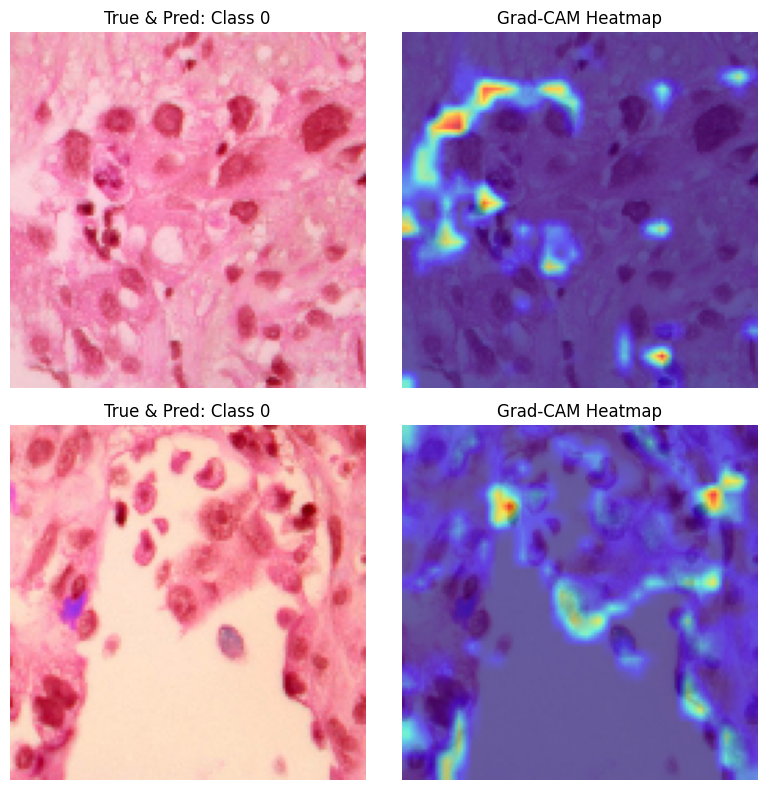

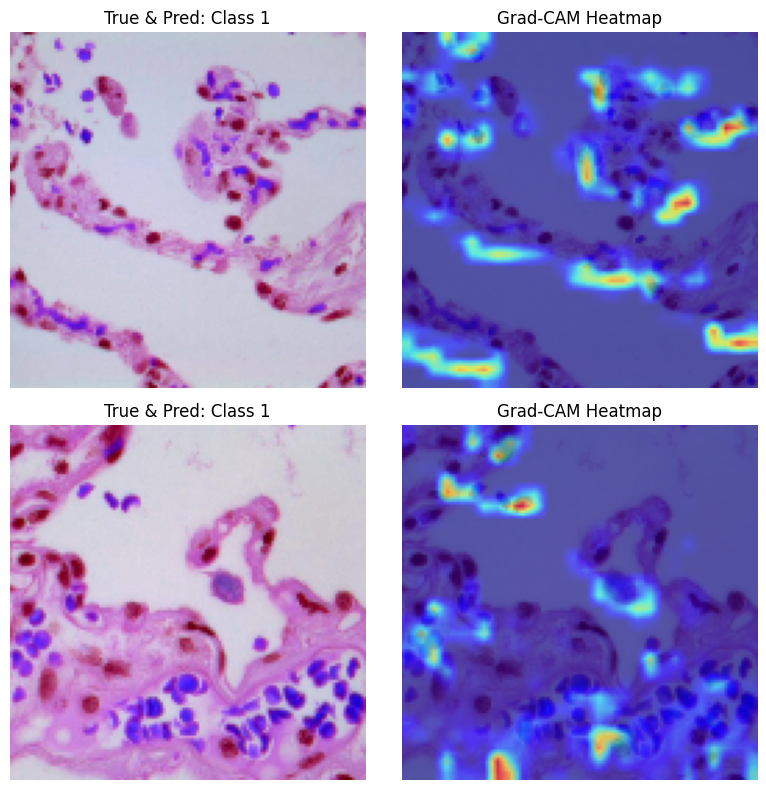

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm

def apply_colormap_on_image(org_im, activation, colormap_name='jet'):
    # Normalize activation map
    heatmap = np.uint8(255 * activation)
    colormap = cm.get_cmap(colormap_name)
    colored_heatmap = colormap(heatmap)
    
    # Drop alpha channel and keep RGB
    colored_heatmap = np.delete(colored_heatmap, 3, axis=2)
    
    # Rescale to original image size and type
    colored_heatmap = np.uint8(255 * colored_heatmap)
    
    # Superimpose
    superimposed_img = cv2.addWeighted(colored_heatmap, 0.6, np.uint8(org_im * 255), 0.4, 0)

    return superimposed_img

def visualize_correct_predictions_by_class(X_test, y_test, y_pred, class_label, model, last_conv_layer_name, num_samples=2):
    count = 0
    plt.figure(figsize=(8, 8))

    for i in range(len(X_test)):
        true_class = np.argmax(y_test[i]) if isinstance(y_test[i], (np.ndarray, list)) else y_test[i]
        pred_class = np.argmax(y_pred[i]) if isinstance(y_pred[i], (np.ndarray, list)) else y_pred[i]

        if true_class == class_label and pred_class == class_label:
            img = X_test[i]
            img_array = np.expand_dims(img, axis=0)

            heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)
            heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
            heatmap_colored = apply_colormap_on_image(img, heatmap_resized)

            plt.subplot(num_samples, 2, 2 * count + 1)
            plt.imshow(img)
            plt.title(f"True & Pred: Class {class_label}")
            plt.axis('off')

            plt.subplot(num_samples, 2, 2 * count + 2)
            plt.imshow(heatmap_colored)
            plt.title("Grad-CAM Heatmap")
            plt.axis('off')

            count += 1
            if count == num_samples:
                break

    plt.tight_layout()
    plt.show()

# Now show for Class 0 and Class 1
visualize_correct_predictions_by_class(X_test, y_test, y_pred, class_label=0, model=model, last_conv_layer_name='conv2d_2')
visualize_correct_predictions_by_class(X_test, y_test, y_pred, class_label=1, model=model, last_conv_layer_name='conv2d_2')